In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")

In [2]:
data1=pd.read_csv('cpu4.csv')
for i in range(len(data1)):
    data1['timestamp'].iloc[i]=datetime.datetime.fromtimestamp(data1['timestamp'].iloc[i]) #We are given the timestamp as a unix code
cols=[i for i in data1.columns if i not in ['timestamp']]
for col in cols:
    data1[col]=pd.to_numeric(data1[col])
data1['timestamp'] = pd.to_datetime(data1['timestamp'])

In [3]:
data1

,timestamp,value,label
0,2016-07-24 20:00:00,0.847300,0
1,2016-07-24 20:05:00,-0.036137,0
2,2016-07-24 20:10:00,0.074292,0
3,2016-07-24 20:15:00,0.074292,0
4,2016-07-24 20:20:00,-0.036137,0
...,...,...,...
17563,2016-09-23 19:35:00,0.074292,0
17564,2016-09-23 19:40:00,0.295152,0
17565,2016-09-23 19:45:00,0.074292,0
17566,2016-09-23 19:50:00,-0.146567,0


In [4]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17568 entries, 0 to 17567
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  17568 non-null  datetime64[ns]
 1   value      17568 non-null  float64       
 2   label      17568 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 411.9 KB


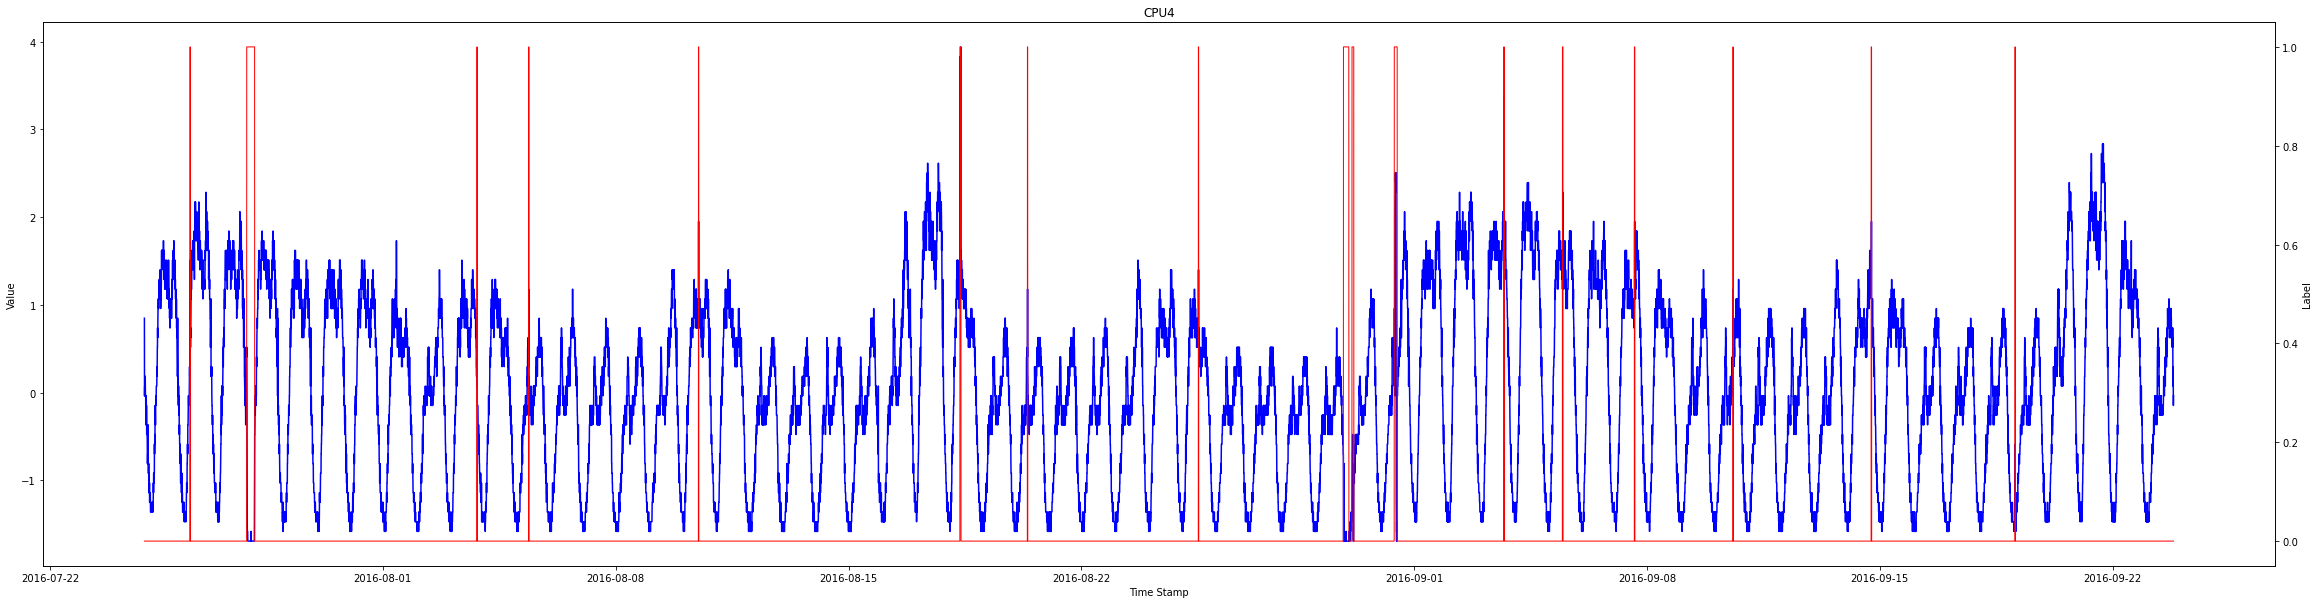

In [5]:
fig, ax2d = plt.subplots(figsize=(40,10))
ax2a = ax2d.twinx()
ax2d.plot(data1['timestamp'], data1['value'], color='blue')
ax2a.plot(data1['timestamp'], data1['label'], color='red', linewidth='1')
ax2d.set_xlabel('Time Stamp')
ax2d.set_ylabel('Value')
ax2a.set_ylabel('Label')
ax2d.title.set_text('CPU4')

In [6]:
train1=data1[['timestamp', 'value']]
datetime_series1 = pd.to_datetime(train1['timestamp'])
datetime_index1 = pd.DatetimeIndex(datetime_series1.values)
period_index1 = pd.PeriodIndex(datetime_index1, freq='S')
train1 = train1.set_index(period_index1)
train1.drop('timestamp',axis=1,inplace=True)

In [7]:
train1

,value
2016-07-24 20:00:00,0.847300
2016-07-24 20:05:00,-0.036137
2016-07-24 20:10:00,0.074292
2016-07-24 20:15:00,0.074292
2016-07-24 20:20:00,-0.036137
...,...
2016-09-23 19:35:00,0.074292
2016-09-23 19:40:00,0.295152
2016-09-23 19:45:00,0.074292
2016-09-23 19:50:00,-0.146567


In [8]:
start=1
finish=30
increments=0.100
increments=int(1/increments)
# print(increments)

contamination=(np.linspace(start, finish ,finish*increments))/100

# importing the isloation forest
from sklearn.ensemble import IsolationForest

anomalies1=[]
for i in contamination:
    # copying dataset
    isf_train1 = train1.copy()

    # initializing Isolation Forest
    clf = IsolationForest(max_samples='auto', contamination=i)

    # training
    clf.fit(isf_train1.values)

    # finding anomalies
    isf_train1['Non Contextual Anomaly'] = clf.predict(isf_train1.values) 

    # saving anomalies to a separate dataset for visualization purposes
    # anomalies_single = isf_dataset.query('Anomaly == -1')
    anomalies1.append(isf_train1)

In [9]:
total_contamination=len(anomalies1)

In [10]:
output=anomalies1

In [11]:
True_Positives=[]
False_Positives=[]
True_Negatives=[]
False_Negatives=[]
for j in range(total_contamination):
    TP_single=0
    FP_single=0
    TN_single=0
    FN_single=0
    for i in range(len(output[j]['Non Contextual Anomaly'])):
        if output[j]['Non Contextual Anomaly'].iloc[i] == -1 and data1['label'].iloc[i] == 1:
            TP_single=TP_single+1
        elif output[j]['Non Contextual Anomaly'].iloc[i] == -1 and data1['label'].iloc[i] != 1:
            FP_single=FP_single+1
        elif output[j]['Non Contextual Anomaly'].iloc[i] != -1 and data1['label'].iloc[i] == 1:
            FN_single=FN_single+1
        elif output[j]['Non Contextual Anomaly'].iloc[i] != -1 and data1['label'].iloc[i] != 1:
            TN_single=TN_single+1
    True_Positives.append(TP_single)
    False_Positives.append(FP_single)
    True_Negatives.append(TN_single)
    False_Negatives.append(FN_single)

In [12]:
tp=np.array(True_Positives)
fp=np.array(False_Positives)
tn=np.array(True_Negatives)
fn=np.array(False_Negatives)

In [13]:
precision=tp/(tp+fp)
recall=tp/(tp+fn)

F1_Score=(2*precision*recall)/(precision+recall)

In [14]:
maxf1= np.max(F1_Score)
print(maxf1)

result=np.where(F1_Score==maxf1)
print(result)

0.5625
(array([2, 3]),)


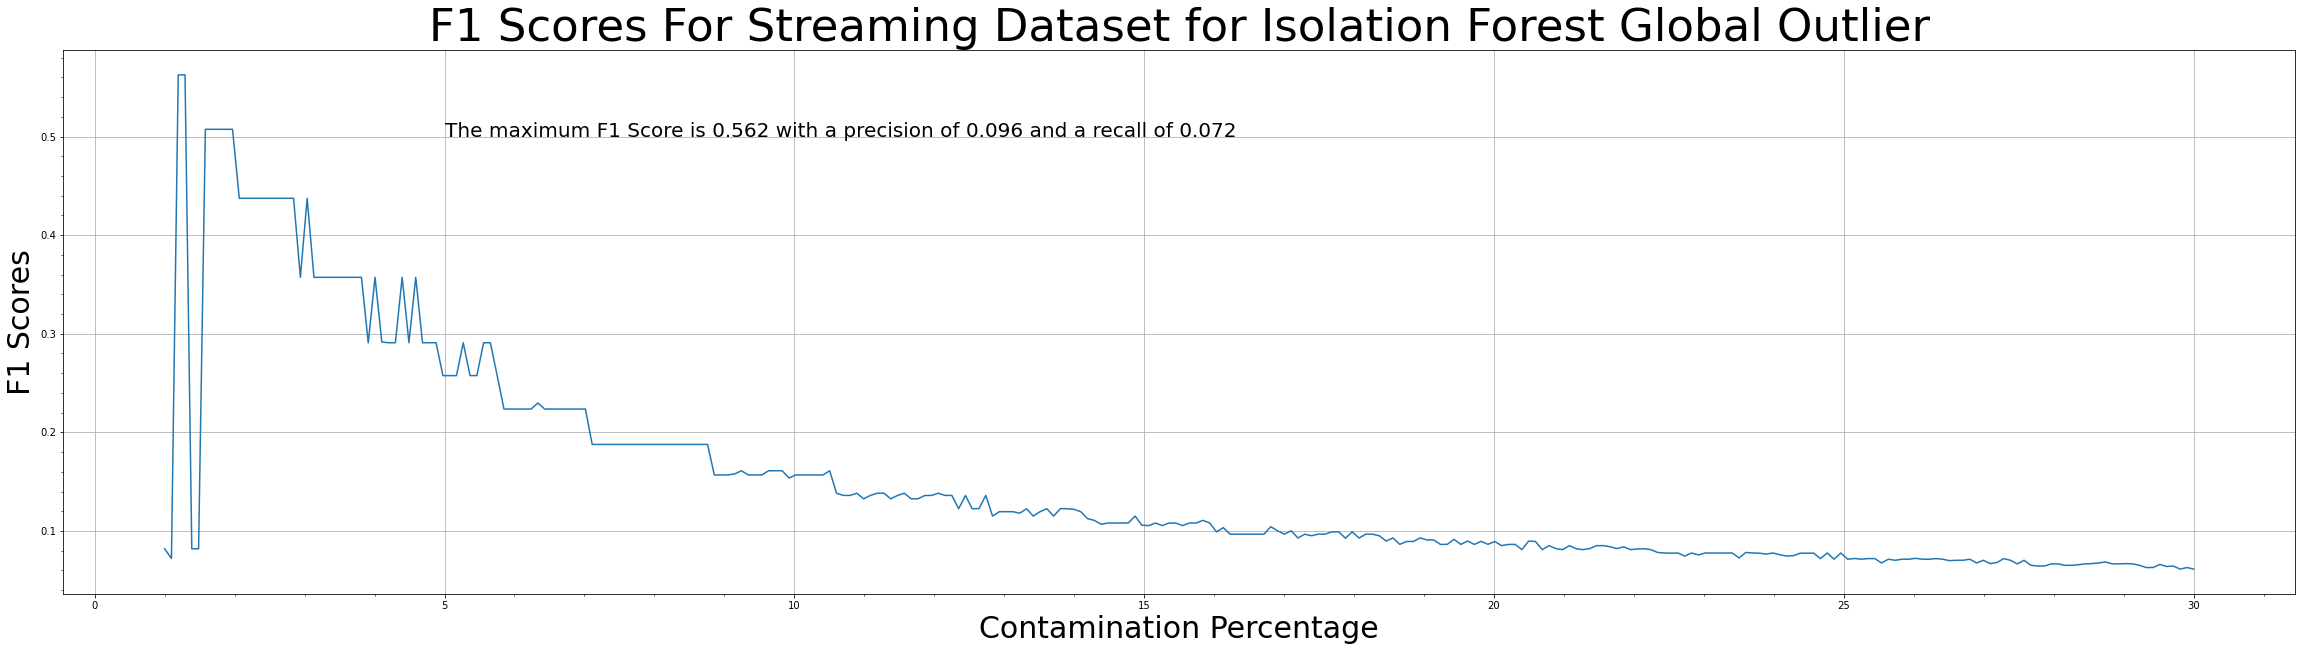

In [15]:
plt.figure(figsize=(40,10))
plt.title("F1 Scores For Streaming Dataset for Isolation Forest Global Outlier", fontsize=45)
plt.xlabel("Contamination Percentage", fontsize=30)
plt.ylabel("F1 Scores", fontsize=30)
plt.plot(contamination*100, F1_Score)

plt.minorticks_on()
plt.grid()
#To show where the contamination is at the maximum F1 Score
big=F1_Score.max()
# big
#print(f"Contamination at max F_{1} Score: {round(contamination[3],5)*100}%")
plt.text(5, 0.5, f"The maximum F1 Score is {round(maxf1,3)} with a precision of {round(precision[4],3)} and a recall of {round(recall[4],3)}", fontsize=20);

plt.savefig('F1 Scores For Streaming Dataset for Isolation Forest Global Outlier.png') 

In [16]:
print(f"Contamination at max F_{1} Score: {round(contamination[4],5)*100}%")
print("")
print(f"Precision: {round(precision[4],3)}")
print(f"Recall: {round(recall[4],3)}")
print(f"F1 Score: {round(maxf1,3)}")

Contamination at max F_1 Score: 1.388%

Precision: 0.096
Recall: 0.072
F1 Score: 0.562
